# <a id='toc1_'></a>[Analyze and visualize NSD-ISS framework applied to the BioFIND cohort](#toc0_)

**Date:** 11/3/2024  
**Author:** Marco Russo, MD, PhD 
https://github.com/dr-russo    

**Libraries**
* pandas  
* numpy
* scikit-learn  
* matplotlib
* seaborn 

**BioFIND Data Files**  n/a 

**Derived Data Files**  
* biofind_composite_data.csv - created by nsd-iss_biofind_tidying.ipynb

**Output**
* biofind_mds-updrs_data.csv - consolidated data table for all MDS-UPDRS data
* figures as separate .svg files

**Abbreviations**  
PD: Parkinson's disease
BioFIND: Fox Investigation for New Discovery of Biomarkers (BioFIND) cohort study
LEDD: levdopa-equivalent daily dose
MDS-UPDRS: Movement Disorder Society Unified Parkinson’s Disease Rating Scale
MoCA: Montreal Cognitive Assessment
NSD: Neuronal Synuclein Disease
ISS: Integrated Staging System
RBD: REM sleep behavior disorder


**Table of contents**<a id='toc0_'></a>    
- [Analyze and visualize NSD-ISS framework applied to the BioFIND cohort](#toc1_)    
    - [Determine NSD status of BioFIND participants with aSyn-SAA data](#toc1_1_1_)    
    - [CSF Alpha-synuclein Seed Amplification Assay Results in BioFIND](#toc1_1_2_)    
    - [Determine NSD-ISS stages for BioFIND cohort](#toc1_1_3_)    
    - [Descriptive statistics of clinical measures for each ISS stage in BioFIND](#toc1_1_4_)    
    - [Calculate cognitive / motor / non-motor anchors separately](#toc1_1_5_)    
    - [Number of S+ BioFIND participants within each ISS stage - Figure 1A](#toc1_1_6_)    
    - [Distribution of disease duration within each stage - Figure 1B](#toc1_1_7_)    
    - [MDS-UPDRS Part III vs. Part II for each ISS Stage - Figure 1C](#toc1_1_8_)    
    - [Distribution of H&Y Stage within each ISS stage - Figure 1D](#toc1_1_9_)    
    - [Distribution of PD vs PIGD motor phenotypes within each ISS stage - Figure 1E](#toc1_1_10_)    
    - [MOCA vs. MDS-UPRDS Part I Question 1 - Figure 1F](#toc1_1_11_)    
    - [Stage distributions according to quartiles of disease duration](#toc1_1_12_)    
    - [Distribution of stages according to disease duration >median (longer disease duration) vs < median (shorter disease duration)](#toc1_1_13_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns

In [3]:
# Set display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 500)

# Enable multiline outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set float formatting
from IPython.display import display
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
# Load biofind composite dataframe created by nsd-iss_biofind_tidying.ipynb
data = pd.read_csv("biofind_composite_data.csv", header=0)

### <a id='toc1_1_1_'></a>[NSD Status of BioFIND Cohort](#toc0_)

In [6]:
# Show value counts for each SAA result set
data["SAA_AG"].value_counts()
data["SAA_BC"].value_counts()
data["SAA_CS"].value_counts()

SAA_AG
Positive    105
Negative      3
Name: count, dtype: int64

SAA_BC
Positive                   105
Negative                     2
Inconclusive (Negative)      1
Name: count, dtype: int64

SAA_CS
Positive               103
Negative                 5
Positive (doubtful)      1
Name: count, dtype: int64

In [7]:
# 'Score' each SAA result condition to facilitate selecting only those with 2 positive results out of 3
saa_result = {
    "Positive": 1,
    "Negative": 0,
    "Inconclusive (Negative)": 0.25,
    "Positive (doubtful)": 0.25,
}

In [8]:
data["SAA_SCORE"] = (
    data["SAA_AG"].apply(lambda id: saa_result.get(id, 0.5))
    + data["SAA_BC"].apply(lambda id: saa_result.get(id, 0))
    + data["SAA_CS"].apply(lambda id: saa_result.get(id, 0))
)

In [ ]:
# Look at distribution of SAA 'scores'
data["SAA_SCORE"].value_counts().sort_index()

SAA_SCORE
0.00      2
0.50     10
1.00      1
1.25      1
1.50      1
2.00      1
2.25      1
3.00    102
Name: count, dtype: int64

### <a id='toc1_1_2_'></a>[CSF $\alpha$-Syn-SAA Results in BioFIND](#toc0_)

|                     | AGreen  | BCaughey  | CSoto |
|----------------------:|:-------:|:--------: |:-----:|
| Positive                | 105     | 105       | 103   |
| Negative                |  3      |  2        | 5     |
| Inconclusive (Negative) |     -    |  1        |     -  |
| Positive ('doubtful')   |     -   |      -     | 1     |

AG : 97.2% positive

In [10]:
# SAA POSITIVE iff SAA score indicates agreement on 2 or more assays
# SAA_SCORE is sum of scores across the 3 assays
data["SAA_RESULT"] = data["SAA_SCORE"].apply(lambda x: True if x >= 2.0 else False)

In [11]:
data["SAA_RESULT"].value_counts()

SAA_RESULT
True     104
False     15
Name: count, dtype: int64

In [12]:
# Select only SAA positive participants
data_spos = data[data["SAA_RESULT"]]

In [ ]:
# Uncomment to save composite data with SAA result attached
# data.to_csv('biofind_composite_data_saa_positive.csv', header=True)

In [ ]:
data_spos["MOCA_U24"] = data_spos["MCATOT"].apply(lambda x: 1 if x <= 24 else 0)

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/348819507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spos['MOCA_U24'] = data_spos['MCATOT'].apply(lambda x: 1 if x <= 24 else 0)


---

### <a id='toc1_1_3_'></a>[NSD-ISS Stages for BioFIND Cohort](#toc0_)

**STAGING ANCHORS FOR NSD-ISS** 

|  	|  	| 	|  	|  	| Anchors of clinical signs or symptoms (stages 2A and 2B) and functional impairment (stages 3-6)<sup>1, 2</sup> 	|
|---	|:---:	|:---:	|:---:	|---	|---	|
|   Stage   	|   S   	|   D<sup>a</sup>   	|   G   	|   Domain   	|   Anchor(s)   	|
|   Stage 0   	|   -   	|   -   	|   SNCA<sup>b</sup>   	|   —   	|   —   	|
|   Stage 1A   	|   +   	|   -   	|   ±   	|   (1) Cognitive <br>   (2) Motor <br>   (3) Other non-motor   	|   (1) MDS-UPDRS item 1.1 = 0; and <br>   (2a) Does not have subthreshold parkinsonism<sup>c</sup>; **and** (2b) is not on PD meds; and  <br> (3a) Does not have RBD; and (3b) is not hyposmic<sup>d</sup>   	|
|   Stage 1B   	|   +   	|   +   	|   ±   	|  	|  	|
|   Stage 2A   	|   +   	|   -   	|   ±   	|   (1) Cognitive<br>    (2) Motor<br>    (3) Other non-motor<br>   	|   (1) Item 1.1 = 1 AND MoCA ≥ 25; or<br>    (2a) Has subthreshold parkinsonism<sup>c</sup>; or (2b) is on PD meds; or<br>    (3a) Has RBD; or (3b) is hyposmic<sup>d</sup>   	|
|   Stage 2B   	|   +   	|   +   	|   ±   	|  	|  	|
|   Stage 3   	|   +   	|   +   	|   ±   	|   (1) Cognitive<br>    (2) Motor<br>   	|   (1a) Item 1.1 = 1 AND MoCA ≤ 24; or (1b) Item 1.1 = 2 AND MoCA ≥ 25; or <br>    (2) MDS-UPDRS-II = 3-13 AND either subthreshold parkinsonism<sup>c</sup> or PD meds   	|
|   Stage 4   	|   +   	|   +   	|   ±   	|   (1) Cognitive<br>    (2) Motor<br>    (3) Other non-motor   	|   (1a) Item 1.1 = 2 and MoCA ≤ 24; or (1b) item 1.1 = 3 AND MoCA ≥ 25; or<br>    (2) MDS-UPDRS-II = 14-26; or<br>    (3) MDS-UPDRS-I (excluding item 1.1) = 13-24<sup>e</sup>   	|
|   Stage 5   	|   +   	|   +   	|   ±   	|   (1) Cognitive<br>   (2) Motor<br>    (3) Other non-motor   	|   (1a) Item 1.1 = 3 AND MoCA ≤ 24; or (1b) item 1.1 = 4 AND MoCA ≥ 25; or<br>    (2) MDS-UPDRS-II = 27-39; or<br>    (3) MDS-UPDRS-I (excluding item 1.1) = 25-36   	|
|   Stage 6   	|   +   	|   +   	|   ±   	|   (1) Cognitive<br>    (2) Motor<br>    (3) Other non-motor   	|   (1) Item 1.1 = 4 AND MoCA ≤ 24; or<br>    (2) MDS-UPDRS-II ≥ 40; or<br>    (3) MDS-UPDRS-I (excluding item 1.1) ≥ 37   	|

*1* Presence of qualifying signs/ symptoms in any single domain qualifies for stage 2 but individuals can have combination in all 3 domains.<br>
*2* Presence of qualifying functional impairment in any single domain qualifies for stage 3-6 but individuals can have combination in all 3 domains.<br>
*a* D positivity defined as < 75% age/sex-expected lowest putamen SBR.<br>
*b* Only fully penetrant pathogenic SNCA variants qualify for Stage 0.<br>
*c* Subthreshold parkinsonism defined as **MDS-UPDRS-III ≥ 5** excluding postural and action tremor.<br>
*d* Hyposmia defined as UPSIT percentile ≤ 15 (age and sex adjusted).<br>
*e* MDS-UPDRS-I (excluding item 1.1) ≥ 13 is sufficient for stage 4 provided that stage 2 criteria are met.<br>


<ref>Dam, T. et al. Neuronal alpha-Synuclein Disease integrated staging system performance in PPMI, PASADENA, and SPARK baseline cohorts. npj Parkinsons Disease 10, 178 (2024).</ref>

**MDS-UPDRS Question 1.1 | COGNITIVE IMPAIRMENT**<br>
This question & its response takes pivotal role in the NSD-ISS and so is elaborated here:
>Consider all types of altered level of cognitive function including cognitive slowing, impaired reasoning, memory loss, deficits in attention and orientation. Rate their impact on activities of daily living as perceived by the patient and/or caregiver.
>Instructions to patient [and caregiver]: Over the past week have you had problems remembering things, following conversations, paying attention, thinking clearly, or finding your way around the house or in
>town?
* (0) Normal: No cognitive impairment.
* (1) Slight: Impairment appreciated by patient or caregiver with no concrete interference with the patient’s ability to carry out normal activities and social interactions.
* (2) Mild: Clinically evident cognitive dysfunction, but only minimal interference with the patient’s ability to carry out normal activities and social interactions.
* (3) Moderate: Cognitive deficits interfere with but do not preclude the patient’s ability to carry out normal activities and social interactions.
* (4) Severe: Cognitive dysfunction precludes the patient’s ability to carry out normal activities and social interactions.

In [22]:
# [Inelegant] function for assigning stage to each subject
# Note, absent UPSIT data and DaT-SPECT data are limitations of BioFIND dataset


def func_staging(row):
    if (
        ((row["NP1COG"] == 4) and (row["MCATOT"] <= 24))
        or (row["P2TOT"] >= 40)
        or (row["P1TOT"] >= 37)
    ):
        return 6
    elif (
        ((row["NP1COG"] == 3) and (row["MCATOT"] <= 24))
        or ((row["NP1COG"] == 4) and (row["MCATOT"] >= 25))
        or (row["P2TOT"] >= 27 and row["P2TOT"] <= 39)
        or ((row["P1TOT"] >= 25) and (row["P1TOT"] <= 36))
    ):
        return 5
    elif (
        ((row["NP1COG"] == 2) and (row["MCATOT"] <= 24))
        or ((row["NP1COG"] == 3) and (row["P2TOT"] >= 25))
        or (row["P2TOT"] >= 14 and row["P2TOT"] <= 26)
        or ((row["P1TOT"] >= 13) and (row["P1TOT"] <= 24))
        or ((row["P1TOT"] >= 13) and row["PDMEDYN"] == 1 and row["RBD_STATUS"])
    ):
        return 4
    elif (
        ((row["NP1COG"] == 1) and (row["MCATOT"] <= 24))
        or ((row["NP1COG"] == 2) and (row["MCATOT"] >= 24))
        or ((row["P2TOT"] >= 3 and row["P2TOT"] <= 13))
        and ((row["P3TOT"] >= 5) or (row["PDMEDYN"] == 1))
    ):
        return 3
    elif (
        ((row["NP1COG"] == 1) and (row["MCATOT"] >= 25))
        or ((row["P3TOT"] >= 5) or (row["PDMEDYN"] == 1))
        or (row["RBD_STATUS"] == 1)
    ):  # No UPSIT
        return 2
    elif ((row["NP1COG"] == 0) and (row["P3TOT"] < 5) and (row["PDMEDYN"] == 0)) and (
        row["RBD_STATUS"] == 0
    ):
        return 1
    else:
        return np.nan

In [ ]:
# Apply the above staging function to all subjects
data_spos.loc[:, "STAGE"] = data_spos.apply(func_staging, axis=1)

### <a id='toc1_1_4_'></a>[Descriptive Statistics for each ISS Stage in BioFIND](#toc0_)

In [ ]:
cols2avg = [
    "STAGE",
    "AGE",
    "DUR_DIAG",
    "P1TOT",
    "P2TOT",
    "P3TOT",
    "P3ON",
    "P3OFF",
    "MCATOT",
    "LEDD",
]
cols2count = ["GENDER", "RBD_STATUS", "MTYPE"]
data_spos[cols2avg].groupby("STAGE").agg([np.nanmean, np.nanstd]).transpose()

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/4008048980.py:14: FutureWarning: The provided callable <function nanmean at 0x105ca3380> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_spos[cols2avg].groupby("STAGE").agg([np.nanmean, np.nanstd]).transpose()
/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/4008048980.py:14: FutureWarning: The provided callable <function nanstd at 0x105ca3d80> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data_spos[cols2avg].groupby("STAGE").agg([np.nanmean, np.nanstd]).transpose()


STAGE                 2      3      4      5
AGE      nanmean  66.41  67.86  69.14  68.60
         nanstd    6.85   6.66   6.34   5.52
DUR_DIAG nanmean   5.10   6.42   7.43  10.76
         nanstd    2.30   2.93   3.61   6.37
P1TOT    nanmean   3.44   7.07  12.54  14.50
         nanstd    3.32   2.97   5.46   3.54
P2TOT    nanmean   1.44   8.60  16.06  26.50
         nanstd    0.73   3.16   4.54   6.36
P3TOT    nanmean  19.33  24.53  29.34  44.00
         nanstd    7.79  12.29  13.09   7.07
P3ON     nanmean  19.33  24.53  29.34  44.00
         nanstd    7.79  12.29  13.09   7.07
P3OFF    nanmean  26.78  33.83  37.91  53.00
         nanstd    6.44  12.45  10.27  15.56
MCATOT   nanmean  27.44  27.22  26.23  25.50
         nanstd    1.74   2.44   2.43   4.95
LEDD     nanmean 219.06 273.84 260.51 310.01
         nanstd  131.27 284.69 464.61 281.95

In [ ]:
data_spos[cols2avg].agg([np.nanmean, np.nanstd]).transpose()
# spos.groupby(list(df.select_dtypes(exclude=[np.number]))).agg(np.median).reset_index()

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_56554/286359019.py:1: FutureWarning: The provided callable <function nanmean at 0x1141c0d60> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  spos[cols2avg].agg([np.nanmean, np.nanstd]).transpose()
/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_56554/286359019.py:1: FutureWarning: The provided callable <function nanstd at 0x1141c1760> is currently using Series.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  spos[cols2avg].agg([np.nanmean, np.nanstd]).transpose()


,nanmean,nanstd
STAGE,3.29,0.65
AGE,68.18,6.51
DUR_DIAG,6.73,3.26
P1TOT,8.74,5.03
P2TOT,10.84,6.11
P3TOT,26.08,12.67
P3ON,26.08,12.67
P3OFF,34.96,11.92
MCATOT,26.88,2.44
LEDD,764.25,603.39


In [ ]:
# Get gender for each stage
data_spos.groupby("STAGE")["GENDER"].value_counts().sort_index

<bound method Series.sort_index of STAGE  GENDER
2      2          5
       1          4
3      2         35
       1         23
4      2         19
       1         16
5      2          2
Name: count, dtype: int64>

### <a id='toc1_1_5_'></a>[Cognitive/Motor/Non-motor Anchors Calculated Independently](#toc0_)

In [14]:
# Define functions to calculate the cognitive, motor, and non-motor stages for NSD-ISS


# Calculate cognitive score (stage) separately
def cogscore(row):
    if row["NP1COG"] == 0:
        return 1
    elif row["NP1COG"] == 1 and row["MCATOT"] >= 25:
        return 2
    elif (row["NP1COG"] == 1 and row["MCATOT"] <= 24) or (
        row["NP1COG"] == 2 and row["MCATOT"] >= 25
    ):
        return 3
    elif (row["NP1COG"] == 2 and row["MCATOT"] <= 24) or (
        row["NP1COG"] == 3 and row["MCATOT"] >= 25
    ):
        return 4
    elif (row["NP1COG"] == 3 and row["MCATOT"] <= 24) or (
        row["NP1COG"] == 4 and row["MCATOT"] >= 25
    ):
        return 5
    elif ((row["NP1COG"] == 4) and (row["MCATOT"] <= 24)) or (
        row["P2TOT"] >= 40 or row["P1TOT"] >= 37
    ):
        return 6
    else:
        return np.nan


# Calculate motor score (stage) separately
def motorscore(row):
    if row["P2TOT"] >= 40:
        return 6
    elif row["P2TOT"] >= 27 and row["P2TOT"] <= 39:
        return 5
    elif row["P2TOT"] >= 14 and row["P2TOT"] <= 26:
        return 4
    elif (row["P2TOT"] >= 3 and row["P2TOT"] <= 13) and (
        row["P3TOT"] >= 5 or row["PDMEDYN"]
    ):
        return 3
    elif row["P3TOT"] >= 5 or row["PDMEDYN"]:
        return 2
    else:
        return np.nan


# Calculate non-motor score (stage) separately
def nonmotorscore(row):
    if row["P1TOT"] >= 37:
        return 6
    elif row["P1TOT"] >= 25 and row["P1TOT"] <= 36:
        return 5
    elif row["P1TOT"] >= 13 and row["P1TOT"] <= 24:
        return 4
    elif row["RBD_STATUS"]:  # no hyposmia data
        return 2
    else:
        return np.nan

In [15]:
data_spos.loc[:, "COGSCORE"] = data_spos.apply(cogscore, axis=1)

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/945975057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spos.loc[:,'COGSCORE'] = data_spos.apply(cogscore, axis=1)


In [16]:
data_spos.loc[:, "MOTORSCORE"] = data_spos.apply(motorscore, axis=1)

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/2788556942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spos.loc[:,'MOTORSCORE'] = data_spos.apply(motorscore, axis=1)


In [ ]:
data_spos.loc[:, "NONMOTORSCORE"] = data_spos.apply(nonmotorscore, axis=1)

In [19]:
# Calculate mean stage/'score' for each anchor
data_spos[["COGSCORE", "MOTORSCORE", "NONMOTORSCORE"]].agg("mean", axis=0)

COGSCORE        1.74
MOTORSCORE      3.20
NONMOTORSCORE   2.73
dtype: float64

In [20]:
# FLag those participants that have higher cognitive stage than either motor or non-motor stages
data_spos.loc[:, "COGSCORE_LARGEST"] = (
    data_spos["COGSCORE"] > data_spos["MOTORSCORE"]
) & (data_spos["COGSCORE"] > data_spos["NONMOTORSCORE"])

data_spos[["COGSCORE", "MOTORSCORE", "NONMOTORSCORE", "COGSCORE_LARGEST"]].sort_index()

/var/folders/n4/w6v8srtx4y78szfjzd7pfqhw0000gn/T/ipykernel_15337/3618237554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spos.loc[:,'COGSCORE_LARGEST'] = (data_spos['COGSCORE'] > data_spos['MOTORSCORE']) & (data_spos['COGSCORE'] > data_spos['NONMOTORSCORE'])


### <a id='toc1_1_6_'></a>[Number of S+ BioFIND within each ISS Stage - Figure 1A](#toc0_)

In [25]:
# Count number of participants within each stage
data_spos[data_spos["SAA_RESULT"]]["STAGE"].value_counts().sort_index()

STAGE
2     9
3    58
4    35
5     2
Name: count, dtype: int64

In [27]:
# Numbers participants within each stage with S+ (aSyn-SAA)
stage_nums_spos = [0, 9, 58, 35, 2, 0]
stage_pct_spos = np.array(stage_nums_spos) / sum(stage_nums_spos) * 100

In [28]:
# Plot style and colors
plot_settings = {
    "ytick.labelsize": 14,
    "xtick.labelsize": 14,
    "font.size": 14,
    "figure.figsize": (8, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "lines.linewidth": 1.6,
    "mathtext.fontset": "stix",
    "font.family": "Helvetica",
}

stage_colors = ["#18689D", "#6FB6DB", "#FFF047", "#FB9D4F", "#CB5D51", "#CA0017"]
dict_stage_colors = {
    1: "#18689D",
    2: "#6FB6DB",
    3: "#FFF047",
    4: "#FB9D4F",
    5: "#CB5D51",
    6: "#CA0017",
}

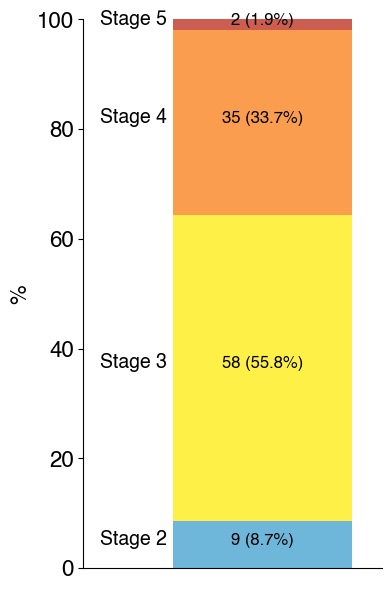

In [ ]:
# Plot stages as percentile fractions, all S+ PD - FIGURE 1A
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=(4, 6))
    colors = stage_colors
    width = 0.6
    bottom = 0
    # Build stacked bar plot:
    for i, col in enumerate(stage_pct_spos):
        ax.bar(1.1, stage_pct_spos[i], width=width, bottom=bottom, color=colors[i])
        bottom += stage_pct_spos[i]

    # Annotate bar plot
    labels = ["Stage 1", "Stage 2", "Stage 3", "Stage 4", "Stage 5", "Stage 6"]
    y_offset = 0
    x_offset = 0.02
    # Add text annotations to each patch of plot
    for n, bar in enumerate(ax.patches):
        if stage_pct_spos[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.1f}%)".format(stage_nums_spos[n], stage_pct_spos[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=12,
            )
            ax.text(
                bar.get_x() - x_offset,
                bar.get_height() + bar.get_y() - bar.get_height() / 2,
                s=labels[n],
                color="k",
                size=14,
                ha="right",
            )

# Additional style adjustments
ax.set_xticks([1])
ax.set_xticklabels("", weight="bold")
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(bottom=False, left=True, labelleft=True)
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.set_xlim([0.5, 1.5])
ax.set_ylabel("%", size=16)
fig.tight_layout(pad=1)

plt.show()

# Uncomment to save figure
# fig.savefig("fig_1a_biofind_spos_stages_numbers_percentages.svg", dpi=300, transparent=True)

### <a id='toc1_1_7_'></a>[Distribution of disease duration within each stage - Figure 1B](#toc0_)

In [ ]:
# Group disease duration by each stage
gb_stage = data_spos.groupby("STAGE")["DUR_DIAG"].agg(["mean", "std"])

x = data_spos["DUR_DIAG"]
y = data_spos["STAGE"]

xmean = gb_stage["mean"]
xerr = gb_stage["std"]

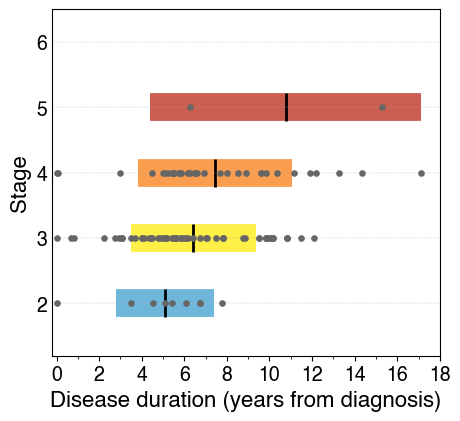

In [ ]:
# Build plot for PD disease duration at each NSD-ISS stage - FIGURE 1B
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=(5, 4.5))

    for index, value in xmean.items():
        ax.errorbar(
            value,
            index,
            xerr=xerr[index],
            ecolor=stage_colors[(index - 1)],
            capsize=0,
            marker="|",
            markersize=20,
            color="k",
            elinewidth=20,
            linewidth=0,
            markeredgewidth=2,
            zorder=0,
        )

    ax.scatter(x, y, s=14, color="#666666", zorder=10)

    ax.set_yticks([1, 2, 3, 4, 5, 6])
    ax.set_xticks(list(range(0, 21, 2)))
    ax.set_xlim(-0.2, 18)
    ax.set_ylim(1.2, 6.5)
    ax.tick_params(axis="y", length=0)

    ax.set_xlabel("Disease duration (years from diagnosis)")
    ax.set_ylabel("Stage")
    # ax.set_title('Disease Duration within Each Stage')
    plt.grid(axis="y", linestyle="--", linewidth=0.25, zorder=-10)

    ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

# Uncomment to save figure
# fig.savefig("fig_1b_disease_duration_across_stages.svg", dpi=300, transparent=True)

### <a id='toc1_1_8_'></a>[MDS-UPDRS Part III vs. Part II for each ISS Stage - Figure 1C](#toc0_)

In [50]:
# P3OFF and P2TOT for each stage
y = data_spos["P3OFF"].values
x = data_spos["P2TOT"].values
stages = data_spos["STAGE"].values
cmap = [dict_stage_colors.get(x) for x in stages]
print(min(x), max(x))

0 31


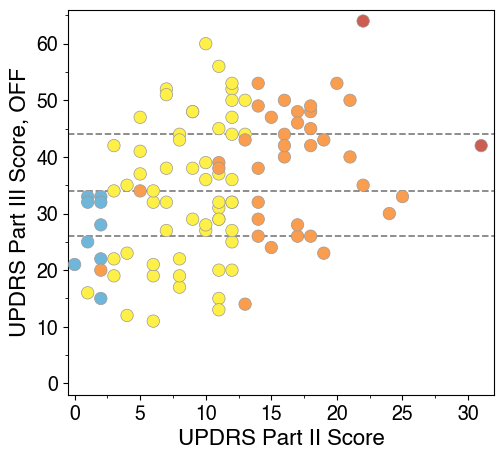

In [ ]:
# MDS-UPDRS Part III vs. Part II - FIGURE 1C
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=(5.5, 5))
    ax.scatter(
        x,
        y,
        color=cmap,
        linewidth=0.5,
        edgecolors="#9A9A9A",
        marker="o",
        s=80,
        zorder=10,
    )
    plt.axhline(y=26, linestyle="--", color="gray", linewidth=1.25)
    plt.axhline(y=34, linestyle="--", color="gray", linewidth=1.25)
    plt.axhline(y=44, linestyle="--", color="gray", linewidth=1.25)
    ax.set_ylim(-2, 66)
    ax.set_xlim(-0.5, 32)
    ax.yaxis.set_ticks(np.arange(0, 64, 10))
    ax.xaxis.set_ticks(np.arange(0, 32, 5))
    ax.set_ylabel("UPDRS Part III Score, OFF")
    ax.set_xlabel("UPDRS Part II Score")

    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.yaxis.set_minor_locator(MultipleLocator(1))

    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


plt.show();

# Uncomment to save figure 
# fig.savefig("figure_xx_p3score_v_p2score_stages.svg", dpi=300, transparent=True)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = x.reshape(-1,1)

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R-squared
r2 = r2_score(y, y_pred)

print("R-squared:", r2)

LinearRegression()

R-squared: 0.14420470659193696


### <a id='toc1_1_9_'></a>[Distribution of H&Y Stage within each ISS stage - Figure 1D](#toc0_)

In [40]:
# Determine number each HY stage within each ISS stage

data_spos.groupby("NHY")["STAGE"].value_counts().sort_index()

NHY  STAGE
1    2         1
     3        15
     4         4
2    2         8
     3        41
     4        21
     5         1
3    3         2
     4         9
     5         1
4    4         1
Name: count, dtype: int64

In [ ]:
# Create lists of numbers participants in each NSD-ISS stage vs. HY stage
hy1 = [0, 1, 15, 4, 0, 0]
hy2 = [0, 8, 41, 21, 1, 0]
hy3 = [0, 0, 2, 9, 1, 0]
hy4 = [0, 0, 0, 1, 0, 0]

hy1pct = (np.array(hy1) / sum(hy1) * 100).round(1)
hy2pct = (np.array(hy2) / sum(hy2) * 100).round(1)
hy3pct = (np.array(hy3) / sum(hy3) * 100).round(1)
hy4pct = (np.array(hy4) / sum(hy4) * 100).round(1)

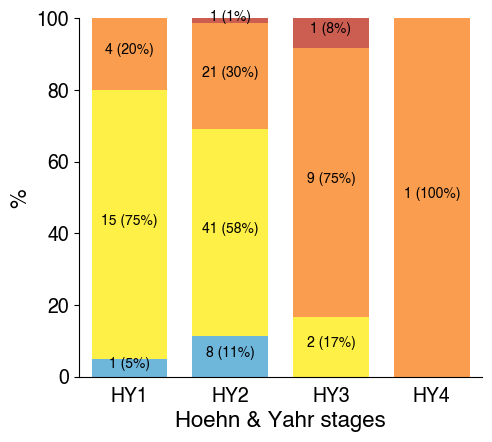

In [ ]:
# Build stacked bar plot for each HY stage with distribution of NSD-ISS stages - FIGURE 1D
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=[5, 4.5])
    colors = stage_colors
    bottom = 0  # bottom of 1st bar
    width = 0.75  # bar width
    for i, col in enumerate(hy1pct):
        ax.bar(1, hy1pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += hy1pct[i]  # add to previous
    bottom = 0  # reset bottom
    for i, col in enumerate(hy2pct):
        ax.bar(2, hy2pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += hy2pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy3pct):
        ax.bar(3, hy3pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += hy3pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy4pct):
        ax.bar(4, hy4pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += hy4pct[i]

    # Annotations
    labels = ["", "Stage 2", "Stage 3", "Stage 4", "Stage 5", ""]
    x_offset = 0.4
    y_offset = 0

    # Add numbers and text to first bar
    for n, bar in enumerate(ax.patches[:6]):
        if hy1pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(hy1[n], hy1pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[6:12]):
        if hy2pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(hy2[n], hy2pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
            # ax.text(
            #   bar.get_x() - x_offset,
            #   bar.get_height() + bar.get_y() - bar.get_height()/2,
            #   s=labels[n], color='k', size=10)

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[12:18]):
        if hy3pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(hy3[n], hy3pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[18:24]):
        if hy4pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(hy4[n], hy4pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["HY1", "HY2", "HY3", "HY4"], weight="bold")
ax.set_xlabel("Hoehn & Yahr stages")
ax.set_ylabel("%")
ax.tick_params(bottom=False, left=True, labelleft=True)
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.set_xlim([0.5, 4.5])
fig.tight_layout(pad=1)

plt.show()

# Uncomment to save figure
#fig.savefig("fig_1d_biofind_stages_by_hystage.svg", dpi=300, transparent=True)

In [ ]:
# Descriptive statistics of each group
data_spos["DUR_SYMP"].apply([np.mean, np.median, np.std])
data_spos["AGE"].apply([np.mean, np.std])
data_spos["GENDER"].value_counts()
print("% Males:" + "{:.2f}".format(61 / (43 + 61) * 100))

mean     8.62
median   7.80
std      3.09
Name: DUR_SYMP, dtype: float64

mean   68.18
std     6.48
Name: AGE, dtype: float64

GENDER
2    61
1    43
Name: count, dtype: int64

% Males:58.65


### <a id='toc1_1_10_'></a>[Distribution of PD vs PIGD motor phenotypes within each ISS stage - Figure 1E](#toc0_)

In [42]:
# Numbers of PD vs. PIGD vs. indeterminate motor phenotypes
data_spos.groupby("MOTORTYPE")["STAGE"].count()

MOTORTYPE
IND      9
PIGD    25
TD      61
Name: STAGE, dtype: int64

In [44]:
# Count numbers of TD and PIGD within each stage
data_spos[data_spos["MOTORTYPE"] == "TD"]["STAGE"].value_counts().sort_index()
data_spos[data_spos["MOTORTYPE"] == "PIGD"]["STAGE"].value_counts().sort_index()

STAGE
2     5
3    33
4    22
5     1
Name: count, dtype: int64

STAGE
2     2
3    12
4    10
5     1
Name: count, dtype: int64

In [ ]:
# Calculate fraction of each motor phenotype within each ISS stage
td = np.array([0, 5, 33, 22, 1, 0])
pigd = np.array([0, 2, 12, 10, 1, 0])

td_pct = []
pigd_pct = []

for _, n in enumerate(zip(td, pigd)):
    m1 = n[0]
    m2 = n[1]
    total = m1 + m2
    if total != 0:
        td_pct.append(m1 / total * 100)
        pigd_pct.append(m2 / total * 100)
    else:
        td_pct.append(0)
        pigd_pct.append(0)

print(td_pct)
print(pigd_pct)

[0, 71.42857142857143, 73.33333333333333, 68.75, 50.0, 0]
[0, 28.57142857142857, 26.666666666666668, 31.25, 50.0, 0]


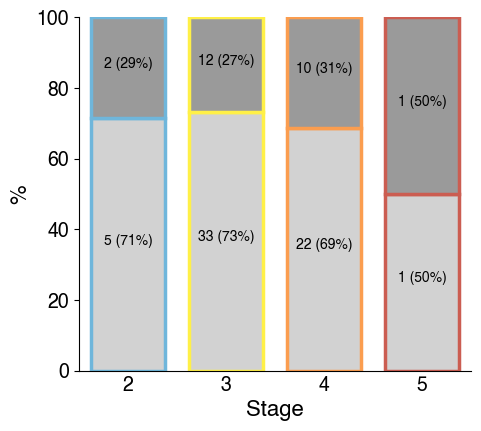

In [ ]:
# Build plot of motor phenotypes across stages - FIGURE 1E
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=(5, 4.5))
    colors = ["#D2D2D2", "#9A9A9A"]
    bottom = 0
    width = 0.75

    for i in range(0, 6):
        ax.bar(
            i + 1,
            td_pct[i],
            width=width,
            bottom=bottom,
            color=colors[0],
            edgecolor=stage_colors[i],
            linewidth=2.5,
        )
        ax.bar(
            i + 1,
            pigd_pct[i],
            width=width,
            bottom=td_pct[i],
            color=colors[1],
            edgecolor=stage_colors[i],
            linewidth=2.5,
        )

    # Annotate
    y_offset = 0
    # x_offset = 0.2
    for n, bar in enumerate(ax.patches[0:12:2]):
        if td_pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height()
                + bar.get_y()
                - bar.get_height() / 2
                + y_offset,  # ypos
                "{} ({:.0f}%)".format(td[n], td_pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
    for n, bar in enumerate(ax.patches[1:12:2]):
        if pigd_pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height()
                + bar.get_y()
                - bar.get_height() / 2
                + y_offset,  # ypos
                "{} ({:.0f}%)".format(pigd[n], pigd_pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    ax.set_xticks([2, 3, 4, 5])
    ax.set_xticklabels(["2", "3", "4", "5"], weight="bold")
    ax.set_ylabel("%")
    ax.tick_params(axis="x", length=0)
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.set_xlim([1.5, 5.5])
    ax.set_ylim(0, 100)
    ax.set_xlabel("Stage")

    fig.tight_layout(pad=1)

plt.show();

# Uncomment to save figure 
# fig.savefig("figure_1e_biofind_td_pigd_w_stages.svg", dpi=300, transparent=True)

In [ ]:
# Separate data by quartiles of UPDRS Part III OFF score
p3quarts = np.quantile(
    data_spos["P3OFF"], [0.25, 0.5, 0.75, 1.0], method="closest_observation"
)
print(p3quarts)

[26. 34. 44. 64.]


In [ ]:
# Count numbers of each ISS stage within each Part 3 quartile
data_spos[data_spos["P3OFF"] <= p3quarts[0]].groupby("STAGE")["STAGE"].count()
data_spos[(data_spos["P3OFF"] > p3quarts[0]) & (data_spos["P3OFF"] <= p3quarts[1])].groupby("STAGE")["STAGE"].count()
data_spos[(data_spos["P3OFF"] > p3quarts[1]) & (data_spos["P3OFF"] <= p3quarts[2])].groupby("STAGE")["STAGE"].count()
data_spos[(data_spos["P3OFF"] > p3quarts[2]) & (data_spos["P3OFF"] <= p3quarts[3])].groupby("STAGE")["STAGE"].count()

STAGE
2     4
3    16
4     7
Name: STAGE, dtype: int64

STAGE
2     5
3    15
4     6
Name: STAGE, dtype: int64

STAGE
3    14
4    11
5     1
Name: STAGE, dtype: int64

STAGE
3    13
4    11
5     1
Name: STAGE, dtype: int64

In [ ]:
# UPDRS Part 3 quartiles
p1 = [0, 4, 16, 7, 0, 0]
p2 = [0, 5, 15, 6, 0, 0]
p3 = [0, 0, 14, 11, 1, 0]
p4 = [0, 0, 13, 11, 1, 0]

p1pct = np.array(p1) / sum(p1) * 100
p2pct = np.array(p2) / sum(p2) * 100
p3pct = np.array(p3) / sum(p3) * 100
p4pct = np.array(p4) / sum(p4) * 100

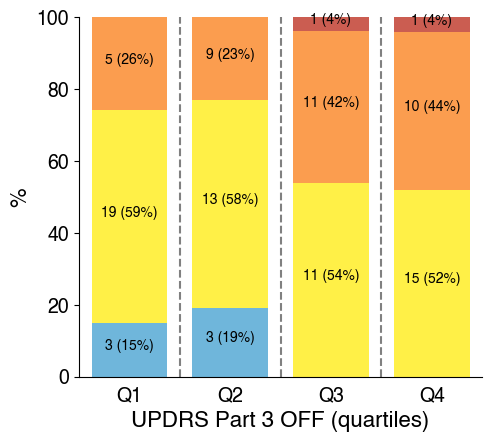

In [ ]:
# Build stacked bar plot for MDS-UPDRS Part 3 quartiles
with plt.style.context(plot_settings):

    fig, ax = plt.subplots(figsize=[5, 4.5])

    colors = stage_colors
    bottom = 0  # bottom of 1st bar
    width = 0.75  # bar width

    for i, col in enumerate(hy1):
        ax.bar(1, p1pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += p1pct[i]  # add to previous
    bottom = 0  # reset bottom
    for i, col in enumerate(hy2):
        ax.bar(2, p2pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += p2pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy3):
        ax.bar(3, p3pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += p3pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy4):
        ax.bar(4, p4pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += p4pct[i]
    # end context

    # Annotations
    labels = ["", "Stage 2", "Stage 3", "Stage 4", "Stage 5", ""]
    x_offset = 0.4
    y_offset = 0

    # Add numbers and text to Q1 bar
    for n, bar in enumerate(ax.patches[:6]):
        if p1[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q1[n], p1pct[n]),
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
        # ax.text(
        #     bar.get_x() - x_offset,
        #     bar.get_height() + bar.get_y() - bar.get_height()/2,
        #     s=labels[n], color='k', size=10
        #     )

    # Add numbers and text to Q2 bar
    for n, bar in enumerate(ax.patches[6:12]):
        if p2[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q2[n], p2pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[12:18]):
        if p3[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q3[n], p3pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[18:24]):
        if p4[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q4[n], p4pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

# order = stage_nums + stage_nums_spos
# stacks = 2
# len(ax.patches) // len(order)

# for a,b in zip(ax.patches[:6],ax.patches[6:]):
#     _,h0 = a.get_xy()
#     _,h1 = b.get_xy()
#     ax.plot([1 + width / 2, 2 - width / 2], [h0, h1], color='C7', ls='dotted', zorder=1)

plt.axvline(x=1.5, linestyle="--", color="gray")
plt.axvline(x=2.5, linestyle="--", color="gray")
plt.axvline(x=3.5, linestyle="--", color="gray")
# plt.text(x=1.5-0.2, y=102, s=f'{quarts[0]:.1f}' + ' years')
# plt.text(x=2.5-0.2, y=102, s=f'{quarts[1]:.1f}' + ' years')
# plt.text(x=3.5-0.2, y=102, s=f'{quarts[2]:.1f}' + ' years')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Q1", "Q2", "Q3", "Q4"], weight="bold")
ax.set_xlabel("UPDRS Part 3 OFF (quartiles)")
ax.set_ylabel("%")
ax.tick_params(bottom=False, left=True, labelleft=True)
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.set_xlim([0.5, 4.5])
fig.tight_layout(pad=1)

plt.show()

# Uncomment to save figure 
# fig.savefig("fig_xx_biofind_stages_by_updrs_part3.svg", dpi=300, transparent=True)

### <a id='toc1_1_11_'></a>[MOCA vs. MDS-UPRDS Part I Question 1 - Figure 1F](#toc0_)

In [ ]:
# NP1COG vs. MCATOT
x = data_spos["NP1COG"].values
y = data_spos["MCATOT"].values
stages = spos["STAGE"].values
cmap = [dict_stage_colors.get(n) for n in stages]

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


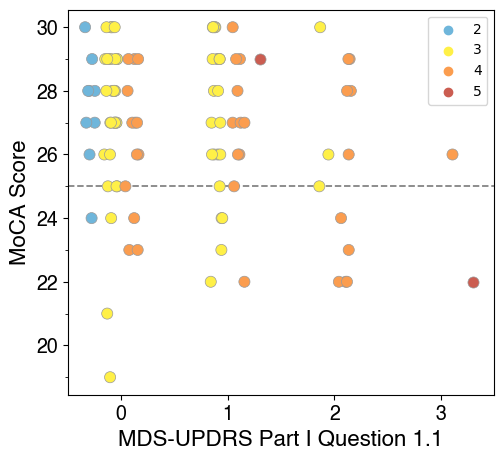

In [ ]:
# MOCA vs. Q1.1 - FIGURE 1F
with plt.style.context(plot_settings):
    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.stripplot(
        ax=ax,
        x="NP1COG",
        y="MCATOT",
        data=spos,
        marker="o",
        edgecolor="#9A9A9A",
        linewidth=0.5,
        hue="STAGE",
        jitter=0.25,
        dodge=True,
        # hue_order=[2,3,4,5],
        alpha=1,
        s=8,
        palette=stage_colors[1:5],
        zorder=10,
    )

    # ax.scatter(x,y,color=cmap, linewidth=0.5, edgecolors='#9A9A9A', marker='o', s=80, zorder=10)
    plt.axhline(y=25, linestyle="--", color="gray", linewidth=1.25)

    ax.set_ylabel("MoCA Score")
    ax.set_xlabel("MDS-UPDRS Part I Question 1.1")
    ax.set_xlim(-0.5, 3.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


# plt.legend()
plt.show()

# Uncomment to save figure
# fig.savefig("figure_1F_q1_v_moca_stages.svg", dpi=300, transparent=True)


### <a id='toc1_1_12_'></a>[Stage distributions according to quartiles of disease duration](#toc0_)

In [ ]:
# Split into quartiles based on disease duration (from diagnosis)
quartiless = np.quantile(
    data_spos["DUR_DIAG"], [0.25, 0.5, 0.75, 1], method="closest_observation"
)
data_spos[data_spos["DUR_DIAG"] <= quarts[0]].groupby("STAGE")["STAGE"].count()
data_spos[
    (data_spos["DUR_DIAG"] > quarts[0]) & (data_spos["DUR_DIAG"] <= quarts[1])
].groupby("STAGE")["STAGE"].count()
data_spos[
    (data_spos["DUR_DIAG"] > quarts[1]) & (data_spos["DUR_DIAG"] <= quarts[2])
].groupby("STAGE")["STAGE"].count()
data_spos[
    (data_spos["DUR_DIAG"] > quarts[2]) & (data_spos["DUR_DIAG"] <= quarts[3])
].groupby("STAGE")["STAGE"].count()

STAGE
2     3
3    19
4     5
Name: STAGE, dtype: int64

STAGE
2     3
3    13
4     9
Name: STAGE, dtype: int64

STAGE
2     3
3    11
4    11
5     1
Name: STAGE, dtype: int64

STAGE
3    15
4    10
5     1
Name: STAGE, dtype: int64

In [ ]:
# Quartiles of disease duration vs. stages
q1 = [0, 3, 19, 5, 0, 0]
q2 = [0, 3, 13, 9, 0, 0]
q3 = [0, 3, 11, 11, 1, 0]
q4 = [0, 0, 15, 10, 1, 0]

q1pct = np.array(q1) / sum(q1) * 100
q2pct = np.array(q2) / sum(q2) * 100
q3pct = np.array(q3) / sum(q3) * 100
q4pct = np.array(q4) / sum(q4) * 100

dur_diag_median = data_spos["DUR_DIAG"].median()

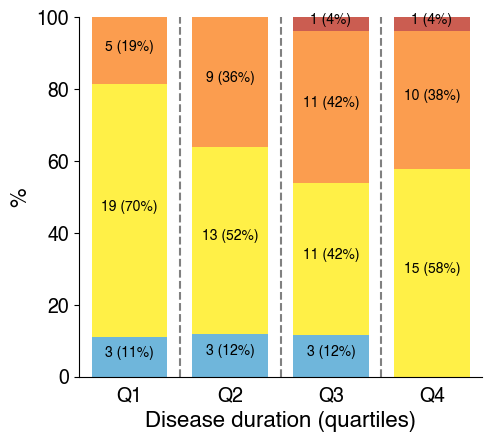

In [ ]:
# Build stacked bar plot for quartiles of disease duration
with plt.style.context(plot_settings):

    fig, ax = plt.subplots(figsize=[5, 4.5])

    colors = stage_colors
    bottom = 0  # bottom of 1st bar
    width = 0.75  # bar width

    for i, col in enumerate(hy1):
        ax.bar(1, q1pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += q1pct[i]  # add to previous
    bottom = 0  # reset bottom
    for i, col in enumerate(hy2):
        ax.bar(2, q2pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += q2pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy3):
        ax.bar(3, q3pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += q3pct[i]
    bottom = 0  # reset bottom
    for i, col in enumerate(hy4):
        ax.bar(4, q4pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += q4pct[i]
    # end context

    # Annotations
    labels = ["", "Stage 2", "Stage 3", "Stage 4", "Stage 5", ""]
    x_offset = 0.4
    y_offset = 0

    # Add numbers and text to Q1 bar
    for n, bar in enumerate(ax.patches[:6]):
        if q1[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q1[n], q1pct[n]),
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
        # ax.text(
        #     bar.get_x() - x_offset,
        #     bar.get_height() + bar.get_y() - bar.get_height()/2,
        #     s=labels[n], color='k', size=10
        #     )

    # Add numbers and text to Q2 bar
    for n, bar in enumerate(ax.patches[6:12]):
        if q2[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q2[n], q2pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[12:18]):
        if q3[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q3[n], q3pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

    # Add numbers and text to second bar
    for n, bar in enumerate(ax.patches[18:24]):
        if q4[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height() + bar.get_y() - bar.get_height() / 2,  # ypos
                "{} ({:.0f}%)".format(q4[n], q4pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )

# order = stage_nums + stage_nums_spos
# stacks = 2
# len(ax.patches) // len(order)

# for a,b in zip(ax.patches[:6],ax.patches[6:]):
#     _,h0 = a.get_xy()
#     _,h1 = b.get_xy()
#     ax.plot([1 + width / 2, 2 - width / 2], [h0, h1], color='C7', ls='dotted', zorder=1)

plt.axvline(x=1.5, linestyle="--", color="gray")
plt.axvline(x=2.5, linestyle="--", color="gray")
plt.axvline(x=3.5, linestyle="--", color="gray")
# plt.text(x=1.5-0.2, y=102, s=f'{quarts[0]:.1f}' + ' years')
# plt.text(x=2.5-0.2, y=102, s=f'{quarts[1]:.1f}' + ' years')
# plt.text(x=3.5-0.2, y=102, s=f'{quarts[2]:.1f}' + ' years')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Q1", "Q2", "Q3", "Q4"], weight="bold")
ax.set_xlabel("Disease duration (quartiles)")
ax.set_ylabel("%")
ax.tick_params(bottom=False, left=True, labelleft=True)
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.set_xlim([0.5, 4.5])
fig.tight_layout(pad=1)

plt.show()

# Uncomment to save figure 
# fig.savefig("fig_1c_biofind_stages_by_duration_quartiles.svg", dpi=300, transparent=True)

### <a id='toc1_1_13_'></a>[Distribution of stages according to disease duration >median (longer disease duration) vs < median (shorter disease duration)](#toc0_)

In [ ]:
# Determine median disease duration and group according >median vs. <median
mdn = spos["DUR_DIAG"].median()
print(mdn)

# Divide S+ subjects according to whether disease onset < median
spos[spos["DUR_DIAG"] <= mdn]["STAGE"].value_counts().sort_index()
spos[spos["DUR_DIAG"] > mdn]["STAGE"].value_counts().sort_index()

6.1287671232876715


STAGE
2     6
3    32
4    14
Name: count, dtype: int64

STAGE
2     3
3    26
4    21
5     2
Name: count, dtype: int64

In [ ]:
# Early <median vs. late >median duration disease
early = [0, 6, 32, 14, 0, 0]
late = [0, 3, 26, 21, 2, 0]

early_pct = np.array(early) / np.sum(early) * 100
late_pct = np.array(late) / np.sum(late) * 100

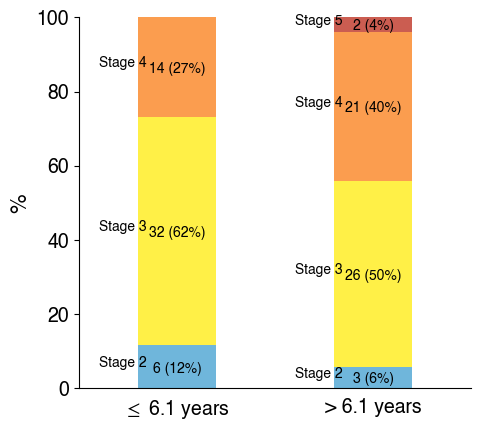

In [ ]:
# Plot of stage distributions for disease duration > median vs. < median
with plt.style.context(plot_settings):
    # Build stacked bar plot for stage fractions
    fig, ax = plt.subplots(figsize=(5, 4.5))
    colors = stage_colors
    bottom = 0
    width = 0.4
    for i, col in enumerate(early):
        ax.bar(1, early_pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += early_pct[i]
    bottom = 0
    for i, col in enumerate(stage_nums_spos):
        ax.bar(2, late_pct[i], width=width, bottom=bottom, color=colors[i])
        bottom += late_pct[i]

    # Annotate
    labels = ["Stage 1", "Stage 2", "Stage 3", "Stage 4", "Stage 5", "Stage 6"]
    y_offset = -1.5
    x_offset = 0.2
    for n, bar in enumerate(ax.patches[:6]):
        if early_pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height()
                + bar.get_y()
                - bar.get_height() / 2
                + y_offset,  # ypos
                "{} ({:.0f}%)".format(early[n], early_pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
            ax.text(
                bar.get_x() - x_offset,
                bar.get_height() + bar.get_y() - bar.get_height() / 2,
                s=labels[n],
                color="k",
                size=10,
            )
    for n, bar in enumerate(ax.patches[6:]):
        if late_pct[n] != 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # xpos
                bar.get_height()
                + bar.get_y()
                - bar.get_height() / 2
                + y_offset,  # ypos
                "{} ({:.0f}%)".format(late[n], late_pct[n]),  # text
                ha="center",
                color="k",
                weight="bold",
                size=10,
            )
            ax.text(
                bar.get_x() - x_offset,
                bar.get_height() + bar.get_y() - bar.get_height() / 2,
                s=labels[n],
                color="k",
                size=10,
            )

    ax.set_xticks([1, 2])
    ax.set_xticklabels([r"$\leq$ 6.1 years", "> 6.1 years"], weight="bold")
    ax.set_ylabel("Time since diagnosis")
    ax.set_ylabel("%")
    ax.tick_params(bottom=False, left=True, labelleft=True)
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.set_xlim([0.5, 2.5])
    fig.tight_layout(pad=1)

plt.show()

# Uncomment to save figure 
# fig.savefig("biofind_stages_early_vs_late_disease.svg", dpi=300, transparent=True)